In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from __future__ import unicode_literals
%matplotlib inline
params = {'legend.fontsize': 15, 'axes.labelsize': 15, 'xtick.labelsize': 15, 'ytick.labelsize': 15,
    'text.usetex': True, 'text.latex.unicode': True,
    'figure.figsize': (8, 8/1.6) }
plt.rcParams.update(params)
torch.set_default_dtype(torch.float64)

In [2]:
MAX = 1
n = 100

def random(n, M = MAX):
    return 2 * (np.random.random(n) - 0.5) * M
    
def log_reg(x, A = A):
    s = torch.zeros(1)
    for i in range(0, A.shape[0]):
        s += torch.log(1 + torch.exp(torch.matmul(A[i], x)))
    return s

def grad_logreg(x, A = A):
    grad = torch.zeros(n)
    for i in range(0, A.shape[0]):
        Ai_x = torch.matmul(A[i], x)
        exp_Ai_x = torch.exp(Ai_x)
        grad += exp_Ai_x / (1 + exp_Ai_x) * A[i]
    return grad

def L_logreg(A):
    matr = torch.zeros([A.shape[1], A.shape[1]])
    for k in range(0, A.shape[0]):
        a_ = A[k]
        for i in range(0, A.shape[1]):
            for j in range(0, A.shape[1]):
                matr[i][j] += a_[i] * a_[j]   
    return matr.norm()

In [3]:
class Iterations:
    def __init__(self, x, iters):
        self.x = x
        self.iters = iters
        
def caution(x):
    if(x.requires_grad):
        print('Input should not require grad')
        return True
    return False

def gradient(f, x):
    if(caution(x)):
        return
    x = torch.tensor(x, requires_grad = True)
    return torch.autograd.grad(outputs = f(x), inputs = x)[0].detach()

def gradient2(f, x):
    if(caution(x)):
        return
    x = torch.tensor(x, requires_grad = True)
    grad = torch.autograd.grad(outputs = f(x), inputs = x, create_graph = True)[0]
    grad2 = torch.zeros([x.shape[0], x.shape[0]])
    for i in range(0, x.shape[0]):
        grad2[i] = torch.autograd.grad(outputs = grad[i], inputs = x, create_graph = True)[0]
    return grad2.detach()

def gradient3(f, x):
    if(caution(x)):
        return
    x = torch.tensor(x, requires_grad = True)
    grad = torch.autograd.grad(outputs = f(x), inputs = x, create_graph = True)[0]
    grad2 = torch.zeros([x.shape[0], x.shape[0]])
    for i in range(0, x.shape[0]):
        grad2[i] = torch.autograd.grad(outputs = grad[i], inputs = x, create_graph = True)[0]
    grad3 = torch.zeros([x.shape[0], x.shape[0], x.shape[0]])
    for i in range(0, x.shape[0]):
        for j in range(0, x.shape[0]):
            grad3[i][j] = torch.autograd.grad(outputs = grad2[i][j], inputs = x, create_graph = True)[0]
    return grad3.detach()

In [4]:
def NAG(f, x_0, gradient, L, eps = 1e-10, max_iter = 1e5):
    iterations = [x_0]
    k = 0
    y_0 = x_0
    gradient_x0 = gradient(x_0)
    
    while(len(iterations) <= max_iter):
        if(gradient_x0.norm() <= eps):
            break
        k += 1
        
        x_k = y_0 - 1./L * gradient(y_0)
        y_k = x_k + (k - 1.)/(k + 2.) * (x_k - x_0)
        
        if(f(x_k) > f(x_0) + torch.matmul(gradient_x0, x_k - x_0) + L/2. * (x_k - x_0).norm()):
            L *= 2
            k -= 1
            continue 
            
        iterations.append(x_k)
        gradient_x0 = gradient(x_k)
        x_0 = x_k
        y_0 = y_k
        
    if(len(iterations) >= max_iter):
        print('NAG did not manage to find precise enough solution')      
    return Iterations(x_k, iterations)

In [5]:
def fNAG(f, x_0, gradient, stop_cr, L, max_iter = 1e5):
    f_opt, eps = stop_cr
    iterations = [x_0]
    k = 0
    y_0 = x_0
    
    while(len(iterations) <= max_iter):
        if(abs(f(x_0) - f_opt) <= eps):
            break
        k += 1
        
        x_k = y_0 - 1./L * gradient(y_0)
        y_k = x_k + (k - 1.)/(k + 2.) * (x_k - x_0)
        
        iterations.append(x_k)
        x_0 = x_k
        y_0 = y_k
        
    if(len(iterations) >= max_iter):
        print('fNAG did not manage to find precise enough solution')   
    return Iterations(x_k, iterations)

In [6]:
def b_r(x, y, x_k, L_3, grad_r_x, grad2_f_xk):
    def r(x):   
        return 0.5 * torch.matmul(torch.matmul(grad2_f_xk, x - x_k), x - x_k) + L_3 * (x - x_k).norm()**4 / 4. 
    
    return r(y) - r(x) - torch.matmul(grad_r_x, y - x)

def g_phi_tau(y, f, x, grad_f_x, grad2_f_x, tau, L_3):
    
    return grad_f_x + torch.matmul(grad2_f_x, y - x) + 0.5 * 1./tau**2 * (
    gradient(f, x + tau * (y - x)) + gradient(f, x - tau * (y - x)) - 2. * grad_f_x
    ) + L_3 * (y - x).norm()**2 * (y - x)

def g_phi(y, f, x, L_3):
    
    return gradient(f, x) + torch.matmul(gradient2(f, x), y - x) + 0.5 * torch.matmul(torch.matmul(
    gradient3(f, x), y - x), y - x
    ) + L_3 * (y - x).norm()**2 * (y - x)
    
def model(y, f, x, L_3):
    
    return torch.matmul(gradient(f, x), y - x) +  1./2 * torch.matmul(torch.matmul(
    gradient2(f, x), y - x), y - x) + 1./6 * torch.matmul(torch.matmul(torch.matmul(
    gradient3(f, x), y - x), y - x), y - x) + L_3/(4.) * (y - x).norm()**4 

In [7]:
def BDGM_oracle_factor(len_iters):
    return n + 1 + 3 * len_iters

def NAG_oracle_factor(len_iters):
    return 1 * len_iters

def HyperFast_oracle_factor(len_iters, BDGM_iters):
    return 1 + BDGM_oracle_factor(BDGM_iters) + 1 * len_iters 

In [13]:
def BDGM(f, x, L_3, tau, axil_eps, axil_iter, max_iter = 3e2):
    iterations = []
    grad2_f_x = gradient2(f, x)
    grad_f_x = gradient(f, x)
    y_k = x
    S = 2. * ((2 + 2**0.5) / L_3 * grad_f_x.norm())**(1./3)
    delt = 1e-6
    #delt = eps**1.5 / (grad_f_x.norm()**0.5 + grad2_f_x.norm()**1.5 / L_3**0.5)
    #tau = 3. * delt / (8 * (2 + 2**0.5) * grad_f_x.norm())
    L = 1.
    while(len(iterations) <= max_iter):
        iterations.append(y_k)
        
        g = g_phi_tau(y_k, f, x, grad_f_x, grad2_f_x, tau, L_3)
        grad_f_yk = gradient(f, y_k)
        if((g.norm() <= 1./6 * grad_f_yk.norm() - delt) | (1./6 * grad_f_yk.norm() - delt <= 0)):
            break
              
        grad_r_yk = torch.matmul(grad2_f_x, y_k - x) + L_3 * (y_k - x).norm()**2 * (y_k - x)
        g_br = lambda y: torch.matmul(g, y - y_k) + 2 * (1 + 1./2**0.5) * b_r(y_k, y, x, L_3, grad_r_yk, grad2_f_x)
        grad_g_br = lambda y: g + 2 * (1 + 1./2**0.5) * (
            torch.matmul(grad2_f_x, y - x) + L_3 * (y - x).norm()**2 * (y - x) - grad_r_yk)
        
        nag_out = NAG(f = g_br, x_0 = y_k, gradient = grad_g_br, L = L, eps = axil_eps, max_iter = axil_iter)
        while(len(nag_out.iters) >= axil_iter):
            if(L >= 1e6):
                break
            L *= 10
            nag_out = NAG(f = g_br, x_0 = y_k, gradient = grad_g_br, L = L, eps = axil_eps, max_iter = axil_iter)
        y_k = nag_out.x
        if((y_k - x).norm() > S):
            print('Solution of axiliary problem is beyond the feasible set BDGM')
            
    if(len(iterations) >= max_iter):
            print('BDGM did not manage to find precise enough solution')
    return Iterations(y_k, iterations)

In [14]:
def bin_srch(f, x_bound, y_bound, max_iter = 20):
    iterations = []
    x_0, x_1 = x_bound
    y_0, y_1 = y_bound
    
    while(len(iterations) <= max_iter):
        x = (x_0 + x_1) / 2.
        f_x = f(x)
        iterations.append(x)
        if(f_x >= y_0):
            if(f_x <= y_1):
                if(len(iterations) >= max_iter):
                    print('bin_srch function has failed')
                return Iterations(x, iterations)
            else:
                x_0 = x
        else:
            x_1 = x

In [15]:
def HyperFast(f, L_3, tau, stop_cr, axil_eps, axil_iter, max_iter):
    f_opt, eps = stop_cr
    BDGM_iters = []
    def BDGM_(x, axil_eps = axil_eps, axil_iter = axil_iter):
        iters = BDGM(f, x, L_3, tau, axil_eps, axil_iter)
        BDGM_iters.append(len(iters.iters))
        return iters.x
    iterations = []
    A_k = 0.
    y_k = x_k = x_k_v = torch.zeros(n)
    
    y_k = BDGM_(x_k_v)
    lam_k = (7./12) / (0.75 * L_3 * (y_k - x_k_v).norm()**2)         
    a_k = 0.5 * (lam_k + (lam_k**2 + 4 * lam_k * A_k)**0.5)
    A_k = A_k + a_k
    x_k = x_k - a_k * gradient(f, y_k)
    iterations.append(y_k)
    
    while(len(iterations) <= max_iter):  
        xi_t = lambda t: (1 - t)**2 * A_k * (1.5 * L_3) / (2 * t) * (
            BDGM_((1 - t) * x_k + t * y_k) - ((1 - t) * x_k + t * y_k)).norm()**2
        t = bin_srch(xi_t, [0., 1.], [0.5, 0.75]).x
        
        x_k_v = (1 - t) * x_k + t * y_k
        y_k = BDGM_(x_k_v)
        lam_k = (1 - t)**2 * A_k / t
        
        C = (lam_k * 0.75 * L_3 * (y_k - x_k_v).norm()**2)
        if((C < 0.5) | (C > 0.75)):
            print('Wrong lambda parameter was found during the work of HyperFast')
            continue
        
        a_k = 0.5 * (lam_k + (lam_k**2 + 4 * lam_k * A_k)**0.5)
        A_k = A_k + a_k
        x_k = x_k - a_k * gradient(f, y_k)
        
        iterations.append(y_k)
        print(len(iterations), f(y_k), f_opt)
        if(abs(f(y_k) - f_opt) <= eps):
            break
    
    if(len(iterations) >= max_iter):
        print('HyperFast did not manage to find precise enough solution')
    return Iterations(y_k, iterations), sum(BDGM_iters)

In [24]:
ns = range(10, 211)[::50]
tau = 0.0002
eps = 1e-4
max_iter = 3e2
axil_eps = 1e-10
axil_iter = 3e3
nag_oracle_compl = []
hf_oracle_compl = []

for n in ns:
    x_0 = torch.zeros(n)
    m = n
    A = torch.zeros([m, n])
    for i in range(0, m):
        A[i] = torch.tensor(random(n, M = 1))
    f = lambda x: log_reg(x, A)
    grad_f = lambda x: grad_logreg(x, A)
    L = L_logreg(A)
    L_3 = 1.
    
    x_opt = NAG(f, x_0, grad_f, L = L, eps = 1e-8, max_iter = 1e5).x
    f_opt = f(x_opt)
    stop_cr = (f_opt, eps)
    
    nag_iters = fNAG(f, x_0, grad_f, stop_cr, L = L, max_iter = 1e5)
    
    hf_iters, BDGM_iters = HyperFast(f, L_3, tau, stop_cr, axil_eps, axil_iter, max_iter)
    
    nag_oracle_compl.append(NAG_oracle_factor(len(nag_iters.iters)))
    hf_oracle_compl.append(HyperFast_oracle_factor(len(hf_iters.iters), BDGM_iters))
    print(n, nag_oracle_compl[-1], hf_oracle_compl[-1])

NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
2 tensor([4.3771]) tensor([3.5041e-07])
3 tensor([3.6959]) tensor([3.5041e-07])
4 tensor([3.1894]) tensor([3.5041e-07])
5 tensor([2.7719]) tensor([3.5041e-07])
6 tensor([2.4202]) tensor([3.5041e-07])
7 tensor([2.1041]) tensor([3.5041e-07])
8 tensor([1.8136]) tensor([3.5041e-07])
9 tensor([1.5326]) tensor([3.5041e-07])
10 tensor([1.2836]) tensor([3.5041e-07])
11 tensor([1.0558]) tensor([3.5041e-07])
12 tensor([0.8719]) tensor([3.5041e-07])
13 tensor([0.7128]) tensor([3.5041e-07])
14 tensor([0.5775]) tensor([3.5041e-07])
15 tensor([0.4641]) tensor([3.5041e-07])
16 tensor([0.3704]) tensor([3.5041e-07])
17 tensor([0.3034]) tensor([3.5041e-07])
NAG did not manage to find precise enough solution
18 tensor([0.2483]) tensor([3.5041e-07])
NAG d

38 tensor([0.0020]) tensor([3.8202e-06])
39 tensor([0.0017]) tensor([3.8202e-06])
40 tensor([0.0015]) tensor([3.8202e-06])
41 tensor([0.0013]) tensor([3.8202e-06])
42 tensor([0.0012]) tensor([3.8202e-06])
43 tensor([0.0010]) tensor([3.8202e-06])
44 tensor([0.0009]) tensor([3.8202e-06])
45 tensor([0.0008]) tensor([3.8202e-06])
46 tensor([0.0007]) tensor([3.8202e-06])
47 tensor([0.0007]) tensor([3.8202e-06])
48 tensor([0.0006]) tensor([3.8202e-06])
49 tensor([0.0005]) tensor([3.8202e-06])
50 tensor([0.0005]) tensor([3.8202e-06])
51 tensor([0.0004]) tensor([3.8202e-06])
52 tensor([0.0004]) tensor([3.8202e-06])
53 tensor([0.0004]) tensor([3.8202e-06])
54 tensor([0.0003]) tensor([3.8202e-06])
55 tensor([0.0003]) tensor([3.8202e-06])
56 tensor([0.0003]) tensor([3.8202e-06])
57 tensor([0.0002]) tensor([3.8202e-06])
58 tensor([0.0002]) tensor([3.8202e-06])
59 tensor([0.0002]) tensor([3.8202e-06])
60 tensor([0.0002]) tensor([3.8202e-06])
61 tensor([0.0002]) tensor([3.8202e-06])
62 tensor([0.000

RuntimeError: latex was not able to process the following string:
b'NAG$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (MiKTeX 2.9.6500 64-bit)
entering extended mode
(C:/Users/zoom_/.matplotlib/tex.cache/d7e1bdf306afdae765c8103fdcba792d.tex
LaTeX2e <2017-04-15>
Babel <3.15> and hyphenation patterns for 75 language(s) loaded.
("C:\Program Files\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex\latex\base\size10.clo"))
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\type1cm\type1cm.sty)
("C:\Program Files\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.def"))
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\ucs.sty
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\uni-global.def))
("C:\Program Files\MiKTeX 2.9\tex\latex\base\inputenc.sty"
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\utf8x.def))
("C:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.sty"
("C:\Program Files\MiKTeX 2.9\tex\latex\graphics\keyval.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.sty")
("C:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file d7e1bdf306afdae765c8103fdcba792d.aux.
("C:\Program Files\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\ucsencs.def)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
<recently read> }
                 
l.15 ...size{15.000000}{18.750000}{\sffamily NAG$}
                                                  
No pages of output.
Transcript written on d7e1bdf306afdae765c8103fdcba792d.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001E4F83E9488> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'NAG$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (MiKTeX 2.9.6500 64-bit)
entering extended mode
(C:/Users/zoom_/.matplotlib/tex.cache/d7e1bdf306afdae765c8103fdcba792d.tex
LaTeX2e <2017-04-15>
Babel <3.15> and hyphenation patterns for 75 language(s) loaded.
("C:\Program Files\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex\latex\base\size10.clo"))
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\type1cm\type1cm.sty)
("C:\Program Files\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.def"))
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\ucs.sty
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\uni-global.def))
("C:\Program Files\MiKTeX 2.9\tex\latex\base\inputenc.sty"
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\utf8x.def))
("C:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.sty"
("C:\Program Files\MiKTeX 2.9\tex\latex\graphics\keyval.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.sty")
("C:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (d7e1bdf306afdae765c8103fdcba792d.aux)
("C:\Program Files\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\ucsencs.def)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
<recently read> }
                 
l.15 ...size{15.000000}{18.750000}{\sffamily NAG$}
                                                  
No pages of output.
Transcript written on d7e1bdf306afdae765c8103fdcba792d.log.




RuntimeError: latex was not able to process the following string:
b'NAG$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (MiKTeX 2.9.6500 64-bit)
entering extended mode
(C:/Users/zoom_/.matplotlib/tex.cache/d7e1bdf306afdae765c8103fdcba792d.tex
LaTeX2e <2017-04-15>
Babel <3.15> and hyphenation patterns for 75 language(s) loaded.
("C:\Program Files\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Program Files\MiKTeX 2.9\tex\latex\base\size10.clo"))
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\type1cm\type1cm.sty)
("C:\Program Files\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.def"))
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\ucs.sty
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\uni-global.def))
("C:\Program Files\MiKTeX 2.9\tex\latex\base\inputenc.sty"
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\utf8x.def))
("C:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.sty"
("C:\Program Files\MiKTeX 2.9\tex\latex\graphics\keyval.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.sty")
("C:\Program Files\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.sty")
("C:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (d7e1bdf306afdae765c8103fdcba792d.aux)
("C:\Program Files\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
(C:\Users\zoom_\AppData\Roaming\MiKTeX\2.9\tex\latex\ucs\ucsencs.def)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
<recently read> }
                 
l.15 ...size{15.000000}{18.750000}{\sffamily NAG$}
                                                  
No pages of output.
Transcript written on d7e1bdf306afdae765c8103fdcba792d.log.




<Figure size 432x288 with 1 Axes>

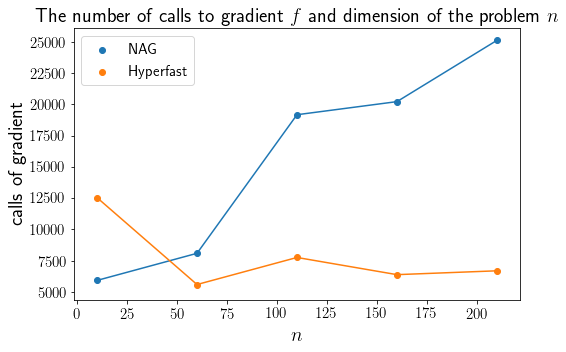

In [42]:
plt.scatter(ns, nag_oracle_compl, label = 'NAG')
plt.plot(ns, nag_oracle_compl)
plt.scatter(ns, hf_oracle_compl, label = 'Hyperfast')
plt.plot(ns, hf_oracle_compl)
plt.xlabel(r'$n$', size = 20)
plt.ylabel('calls of gradient', size = 20)
plt.legend()
plt.title(r'The number of calls to gradient $f$ and dimension of the problem $n$', size = 20)
plt.savefig('HF.pdf')